# Tracking a moving stystem

We consider a state-space model of the form
$$
\begin{aligned}
    p(z_t \vert z_{t-1}) &= {\cal N}(z_t \vert F z_{t-1}, Q_t)\\
    p(y_t \vert z_t) &= \text{St}(y_t \vert  H_t z_t, R_t, \nu)
\end{aligned}
$$

In [1]:
import jax
import datagen
import numpy as np
import jax.numpy as jnp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from functools import partial
from rebayes_mini import callbacks
from rebayes_mini.datasets import linear_ssm
from rebayes_mini.methods import student_t_filter as stf
from rebayes_mini.methods import gauss_filter as kf
from rebayes_mini.methods import robust_filter as rkf
from rebayes_mini.methods import generalised_bayes_filter as gbf

2023-12-11 13:40:36.519719: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

plt.rcParams["font.size"] = 18
cmap = {
    "Robust KF": "crimson",
    "IMQF": "dodgerblue",
    "KF": "lightseagreen"
}

In [3]:
key = jax.random.PRNGKey(314)

## Multiple samples

In [4]:
delta = 0.1
dynamics_covariance = 0.1
obs_covariance = 10.0
dgen = datagen.GaussOutlierMovingObject2D(
    delta, dynamics_covariance, obs_covariance,
    outlier_proba=0.05,
    outlier_scale=100.0,
)


In [5]:
initial_mean = initial_mean = jnp.array([0.0, 0.0, 1.0, 1.0])
n_steps = 500

n_samples = 100
colors = plt.cm.tab10(jnp.arange(n_samples))
colors = plt.cm.viridis(jnp.linspace(0, 1, n_samples))
keys = jax.random.split(key, n_samples)
datasets = jax.vmap(dgen.sample, in_axes=(0, None, None))(keys, initial_mean, n_steps)

yv = datasets["observed"]

(-600.0, 600.0)

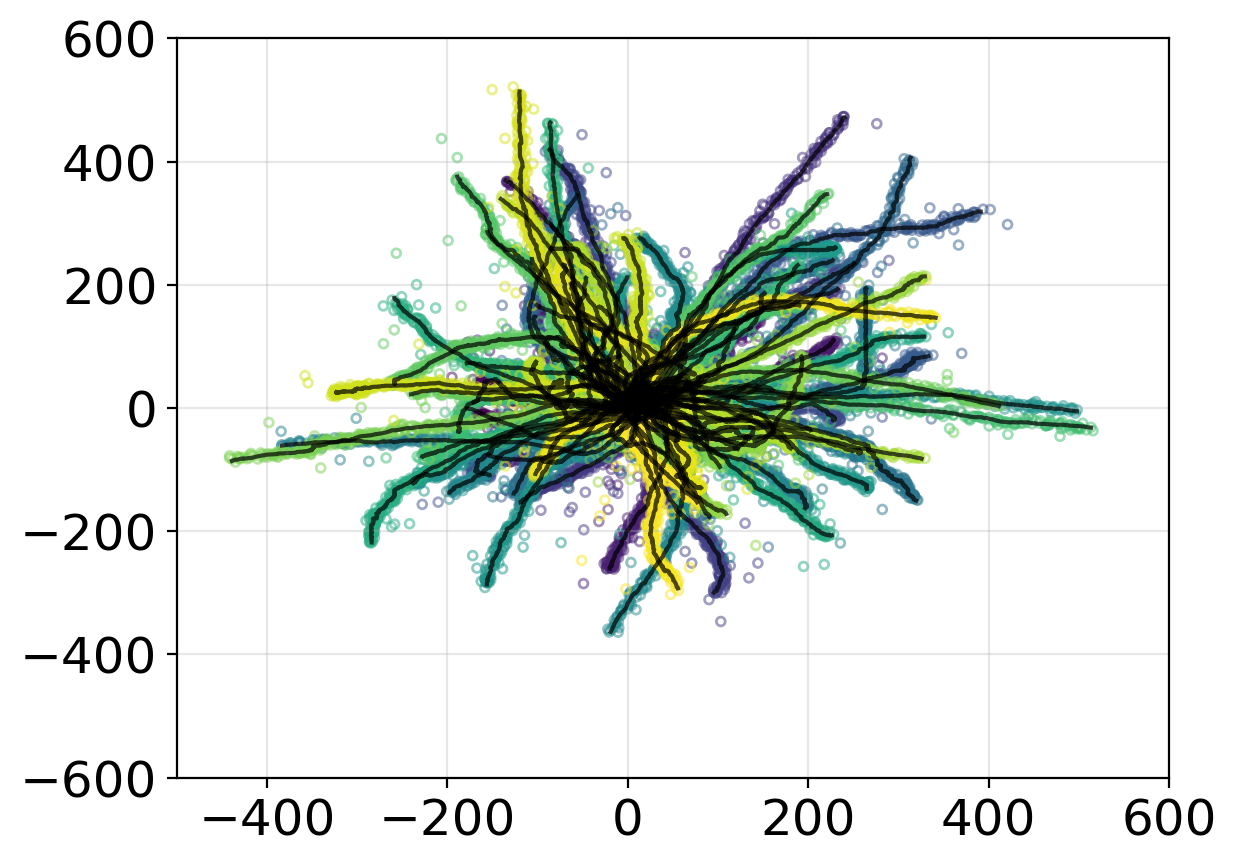

In [6]:
for i, color in enumerate(colors):
    dataset = jax.tree_map(lambda x: np.array(x[i]), datasets)
    plt.plot(*dataset["latent"][:, :2].T, c="black", alpha=0.7)
    plt.scatter(*dataset["observed"].T, edgecolor=color, color="none", s=10, alpha=0.5)
    plt.grid(alpha=0.3)
    
plt.xlim(-500, 600)
plt.ylim(-600, 600)

## Kalman filter

In [7]:
agent_kf = kf.KalmanFilter(
    dgen.transition_matrix,
    dgen.dynamics_covariance,
    dgen.observation_covariance
)


init_bel = agent_kf.init_bel(initial_mean, cov=1.0)

vscan = jax.vmap(
    partial(agent_kf.scan, callback_fn=callbacks.get_updated_mean),
    in_axes=(None, 0, None)
)
_, hist_bel_kf_runs = vscan(
    init_bel, yv, dgen.projection_matrix
)

In [8]:
diff_kf = jnp.power(hist_bel_kf_runs - datasets["latent"], 2)
jnp.sqrt(diff_kf.sum(axis=1)).mean(axis=0)

Array([59.01096 , 58.644497, 40.810135, 41.099766], dtype=float32)

## Robust KF

In [9]:
agent_rkf = rkf.RobustKalmanFilter(
    dgen.transition_matrix,
    dgen.dynamics_covariance,
    dgen.observation_covariance,
    n_inner=1,
    noise_scaling=100
)


In [10]:
init_bel = agent_rkf.init_bel(initial_mean, cov=1.0)

vscan = jax.vmap(
    partial(agent_rkf.scan, callback_fn=callbacks.get_updated_mean),
    in_axes=(None, 0, None)
)
_, hist_bel_rkf_runs = vscan(
    init_bel, yv, dgen.projection_matrix
)

In [11]:
diff_rkf = jnp.power(hist_bel_rkf_runs - datasets["latent"], 2)
jnp.sqrt(diff_rkf.sum(axis=1)).mean(axis=0)

Array([47.93172 , 47.726776, 36.617607, 36.77521 ], dtype=float32)

## Weighted (IMQ) Kalman Filter

In [12]:
def link(z, _):
    mean = dgen.projection_matrix @ z
    return mean


agent_imq = gbf.IMQFilter(
    link,
    dynamics_covariance=dgen.dynamics_covariance,
    observation_covariance=dgen.observation_covariance,
    soft_threshold=14,
    transition_matrix=dgen.transition_matrix,
)

init_bel = agent_imq.init_bel(initial_mean, cov=1.0)
vscan = jax.vmap(
    partial(agent_imq.scan, callback_fn=callbacks.get_updated_mean),
    in_axes=(None, 0, None)
)


_, hist_bel_imq_runs = vscan(
    init_bel, yv, jnp.ones(n_steps)
)

In [13]:
diff_imq = jnp.power(hist_bel_imq_runs - datasets["latent"], 2)
jnp.sqrt(diff_imq.sum(axis=1)).mean(axis=0)

Array([30.885433, 30.941996, 31.541853, 31.415257], dtype=float32)

## Plot comparison

In [14]:
part_imq = pd.DataFrame(np.array(diff_imq.sum(axis=1))).melt()
part_imq["method"] = "IMQF"

part_rkf = pd.DataFrame(np.array(diff_rkf.sum(axis=1))).melt()
part_rkf["method"] = "Robust KF"

part_kf = pd.DataFrame(np.array(diff_kf.sum(axis=1))).melt()
part_kf["method"] = "KF"

In [15]:
diff_df = pd.concat([part_imq, part_rkf, part_kf], axis=0)
diff_df = diff_df.rename(
    {
        "variable": "state",
        "value": "error"
    },
    axis=1
)

diff_df["state"] = diff_df["state"].apply(lambda x: rf"$\theta_{x}$")

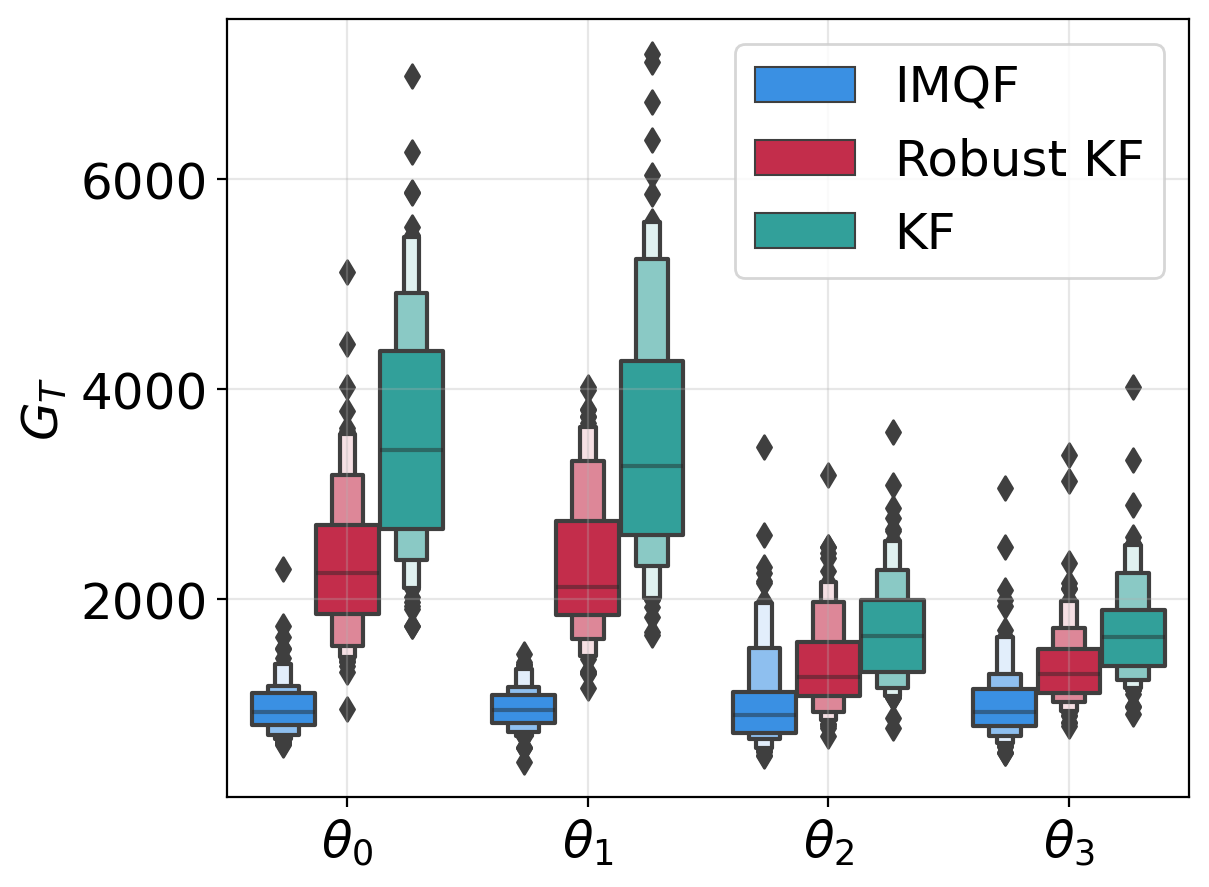

In [26]:
sns.boxenplot(
    y="error",
    x="state",
    hue="method",
    data=diff_df,
    palette=cmap,
    # hue_order=cmap.keys()
)
plt.legend()
plt.xlabel("")
plt.ylabel("$G_T$")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("./figures/2d-ssm-comparison-outlier-covariance.pdf")

## Single model comparison

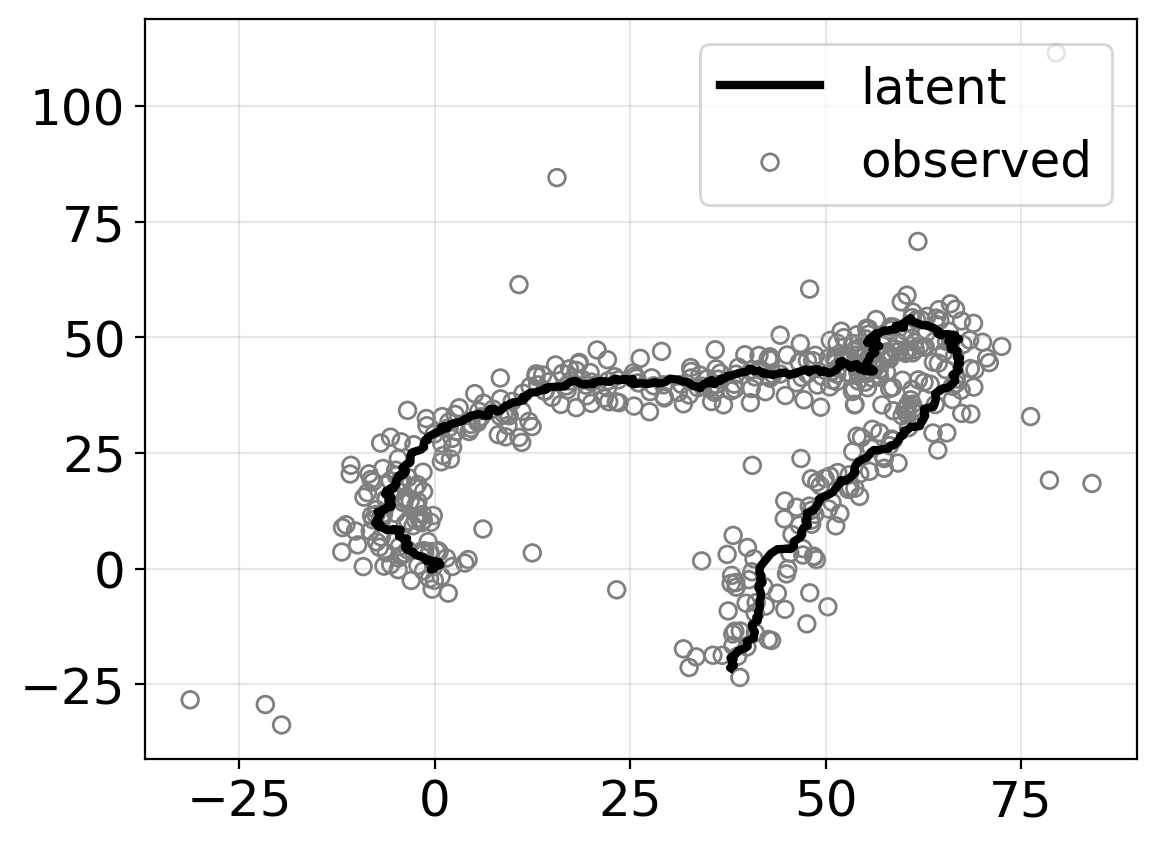

In [37]:
i = 1
latent_i = datasets["latent"][i, :, :2].T
observed_i = yv[i]

plt.plot(*latent_i, c="black", label="latent", linewidth=3)
plt.scatter(*observed_i.T, c="none", edgecolor="tab:gray", label="observed")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("./figures/2d-ssm-sample-outlier-covariance.pdf")

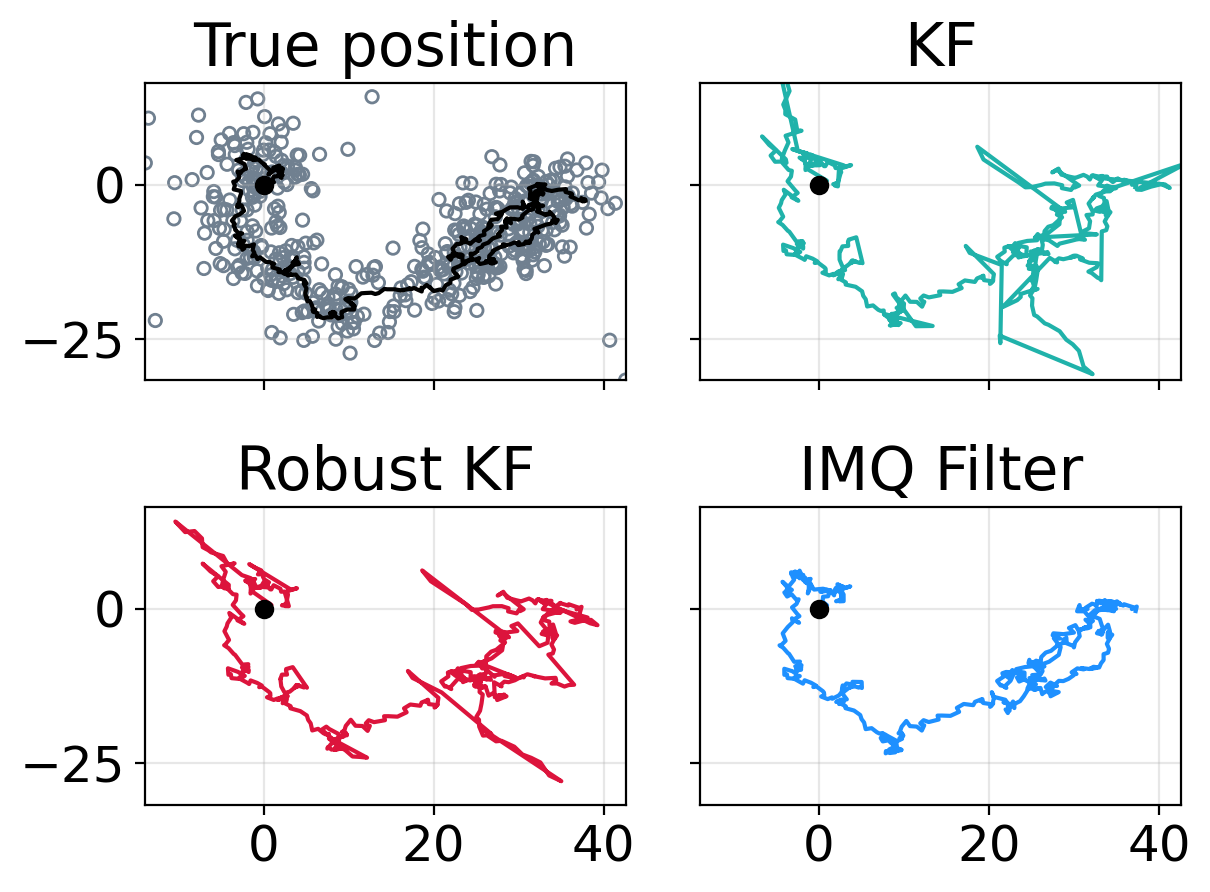

In [35]:
i = 6
latent_i = datasets["latent"][i, :, :2].T
kf_i = hist_bel_kf_runs[i, :, :2].T
rkf_i = hist_bel_rkf_runs[i, :, :2].T
imq_i = hist_bel_imq_runs[i, :, :2].T

fig, ax = plt.subplots(2,2, figsize=(6.4, 4.8), sharex=True, sharey=True)

ax[0,0].plot(*latent_i, c="black")
ax[0,0].set_title("True position")
ax[0,0].scatter(*yv[i, :].T, edgecolor="slategray", color="none", s=20, label="observed")

ylim = ax[0,0].get_ylim()
xlim = ax[0,0].get_xlim()

ax[0,1].plot(*kf_i, c="lightseagreen")
ax[0,1].set_title("KF")

ax[1,0].plot(*rkf_i, c="crimson")
ax[1,0].set_title("Robust KF")

ax[1,1].plot(*imq_i, c="dodgerblue")
ax[1,1].set_title("IMQ Filter")

(xmin, ymin) = np.quantile(yv[i], 0.01, axis=0)
(xmax, ymax) = np.quantile(yv[i], 0.99, axis=0)
for axi in ax.ravel():
    axi.grid(alpha=0.3)
    axi.scatter(0,0, c="black", zorder=3)
    axi.set_xlim(xmin, xmax)
    axi.set_ylim(ymin, ymax)

plt.tight_layout()
plt.savefig("./figures/2d-ssm-comparison-single-run.pdf")